In [1]:
import astropy.units as u
import numpy as np
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic
from astropy.coordinates import SkyCoord, Distance
#import popsims
import matplotlib.pyplot as plt
from popsims.plot_style import  plot_style
from astropy.coordinates import SkyCoord
import astropy.coordinates as astro_coord
import astropy.units as u
from tqdm import tqdm
from popsims.galaxy import Disk, Halo, GalacticComponent
import popsims
from gala.units import UnitSystem

plot_style()

path_plot = '/users/caganze/research/stellarstreams/figures/'
path_data= '/users/caganze/research/stellarstreams/data/stream/'


#function definitions
def get_nfw_profile_from_M200_c(M200, c, rho_c=None):
        r"""
        from_M200_c(M200, c, rho_c=None, units=None, origin=None, R=None)

        Initialize an NFW potential from a virial mass, ``M200``, and a
        concentration, ``c``.

        Parameters
        ----------
        M200 : :class:`~astropy.units.Quantity`, numeric [mass]
            Virial mass, or mass at 200 times the critical density, ``rho_c``.
        c : numeric
            NFW halo concentration.
        rho_c : :class:`~astropy.units.Quantity`, numeric [density]
            Critical density at z=0. If not specified, uses the default astropy
            cosmology to obtain this, `~astropy.cosmology.default_cosmology`.
        """
        if rho_c is None:
            from astropy.constants import G
            from astropy.cosmology import default_cosmology

            cosmo = default_cosmology.get()
            #hubble constant
            rho_c = (3 * cosmo.H(0.0) ** 2 / (8 * np.pi * G)).to(
                u.Msun / u.kpc ** 3
            )

        Rvir = np.cbrt(M200 / (200 * rho_c) / (4.0 / 3 * np.pi)).to(u.kpc)
        r_s = Rvir / c

        A_NFW = np.log(1 + c) - c / (1 + c)
        m = M200 / A_NFW

        return gp.NFWPotential(m=m.to(u.kg), r_s=r_s.to(u.km), a=1.0, b=1.0, c=1.0, units=  usys)

def evolve_orbits_only_as_null(st_coord, time_dict):
    #evolve stream and nbody for a short period without releasing any stars
    particle_pot = [ [gp.NullPotential(units=usys)] * st_coord.shape[0]][0]
    
    nbody = gd.DirectNBody(st_coord, particle_pot, external_potential=pot, save_all=True, units=  usys)

    return  nbody.integrate_orbit(**time_dict)

def get_cyl_rotation(site_at_impact_w0): #borrowed from Adrian Price-Whelan's streampunch github repo
    L = site_at_impact_w0.angular_momentum()
    v = site_at_impact_w0.v_xyz

    new_z = v / np.linalg.norm(v, axis=0)
    new_x = L / np.linalg.norm(L, axis=0)
    new_y = -np.cross(new_x, new_z)
    R = np.stack((new_x, new_y, new_z))
    return R


def get_perturber_w0_at_impact(site_at_impact_w0, psi, v_rho, v_z, vpsi):

    # Get the rotation matrix to rotate from Galactocentric to cylindrical
    # impact coordinates at the impact site along the stream
    R = get_cyl_rotation(site_at_impact_w0)

    psi, v_rho, v_z, vpsi =  psi * u.rad, v_rho*u.km/u.s,  v_z * u.km/u.s, vpsi * u.rad/u.s

    # Define the position of the perturber at the time of impact in the
    # cylindrical impact coordinates:
    perturber_pos = astro_coord.CylindricalRepresentation(rho=0*u.kpc, 
                                                    phi=psi,
                                                    z=0*u.kpc) 

    # Define the velocity in the cylindrical impact coordinates:
    #maybe we want this to have the same vz as the stream?
    perturber_vel = astro_coord.CylindricalDifferential(d_rho=v_rho,d_phi=vpsi,d_z=v_z)

    # Transform from the cylindrical impact coordinates to Galactocentric
    perturber_rep = perturber_pos.with_differentials(perturber_vel)
    perturber_rep = perturber_rep.represent_as(astro_coord.CartesianRepresentation, astro_coord.CartesianDifferential)
    perturber_rep = perturber_rep.transform(R.T)

    pos = perturber_rep.without_differentials() + site_at_impact_w0.pos
    vel = perturber_rep.differentials['s'] + site_at_impact_w0.vel

    # This should be in Galactocentric Cartesian coordinates now!
    return gd.PhaseSpacePosition(pos, vel)

def plot_stream(mock_st, mock_pos, collision_pos, collision_vel, halo_vel, filename, alpha=0.5):
    #visualize 
    fig, (ax, ax1, ax2)=plt.subplots(figsize=(12, 4), ncols=3)

    ax.scatter(mock_st.x, \
               mock_st.y,  s=1, alpha=alpha, c='k')

    ax.scatter(mock_pos.x, mock_pos.y, s=100, c='r')
    ax.scatter(collision_pos.value[0], collision_pos.value[1], s=200, c='y', marker='x')

   
    ax1.scatter(mock_st.x, \
               mock_st.z,  s=1, alpha=alpha, c='k')
    ax1.scatter(mock_pos.x, mock_pos.z, s=100, c='r')
    ax1.scatter(collision_pos.value[0], collision_pos.value[-1], s=200, c='y', marker='x')


    ax2.scatter(mock_st.y, \
               mock_st.z,  s=1, alpha=alpha, c='k')
    ax2.scatter(mock_pos.y, mock_pos.z, s=100, c='r')
    ax2.scatter(collision_pos.value[1], collision_pos.value[-1], s=200, c='y', marker='x')

    V = np.array([[collision_vel.value[0], collision_vel.value[-1]], [halo_vel[0].value, halo_vel[-1].value]])
    origin =[np.array([collision_pos.value[0], collision_pos.value[-1]]), \
    np.array([collision_pos.value[0], collision_pos.value[-1]])]
 

    ax1.quiver(*origin, V[:,0], V[:,1], color=['b', 'b'], scale=21)
    #ax1.quiver((collision_pos.value[0], collision_pos.value[-1]), V[1], color='b', scale=21)

    #ax2.

    #ax2.scatter(mock_st.to_coord_frame(astro_coord.ICRS,  galactocentric_frame=galcen_frame).ra, \
    #           mock_st.to_coord_frame(astro_coord.ICRS, galactocentric_frame=galcen_frame).dec,  s=1, alpha=alpha)
    #ax2.scatter(mock_pos.to_coord_frame(astro_coord.ICRS, galactocentric_frame=galcen_frame).ra, \
    #            mock_pos.to_coord_frame(astro_coord.ICRS, galactocentric_frame=galcen_frame).dec, s=100, c='r')

    ax2.set_xlabel('y (kpc)', fontsize=16)
    ax2.set_ylabel('z (kpc)', fontsize=16)
    ax.set_xlabel('x (kpc)', fontsize=16)
    ax.set_ylabel('y (kpc)', fontsize=16)
    ax1.set_xlabel('x (kpc)', fontsize=16)
    ax1.set_ylabel('z (kpc)', fontsize=16)
    
    #ax2.invert_xaxis()
    #ax.set(xlim=[245, 255], ylim=[-10, 2.5])
    plt.tight_layout()
    plt.savefig(path_plot +'/unpeturbed'+filename+'.jpeg')

def generate_stream_and_perturber(mass, prog_w0, timedict,  nbody=None, output_every=None, output_filename=None, nstars=1000):
    """
    Input: mass of the progenitor, its position, other mockstream generator kwrargs
    Returns: final stream and its position and velocity
    
    Calls mockstream generator
    
    """

    df = ms.FardalStreamDF()
    prog_mass = mass * u.Msun

    gen = ms.MockStreamGenerator(df, H)

    return gen.run(prog_w0, prog_mass, nbody=nbody,\
                   output_every=output_every, output_filename= output_filename, \
                check_filesize=True, overwrite=True,  progress=True, **timedict)

def run_stream_and_subhalo(halo_mass, stream_mass, halo_r, halo_pos, stream_pos, timedict,filename='mockstream',output_every=1, potential_type='plummer', nstars=1000):
    """
    runs a subhalo and a stream 
    
    returns the progenitor position and the final stream
    
    Takes in the parameters of the subhalos
    
    """
    
    #create a plummer sphere 
    point_potential=gp.PlummerPotential(halo_mass*u.Msun,  halo_r*u.pc, units=usys)
    
    #if potential_type
    if  potential_type.lower()=='hern':
        point_potential=gp.HernquistPotential(halo_mass*u.Msun,  halo_r*u.pc, units=usys)
        
    #create an Nbody potential object
    Massive_body=gd.DirectNBody(halo_pos, [point_potential], external_potential=pot)
    return  generate_stream_and_perturber(stream_mass,  stream_pos, timedict, \
                                      nbody=Massive_body,\
                                      nstars=nstars,\
                                    output_every=output_every, \
                                    output_filename=path_data+'/'+filename+'.h5')

def plot_orbit_history(filename, coll_pos):
    bodies, stream=read_stream_file(filename+'.h5')
    
    body0=bodies['pos'][:,:,0 ]
    body1=bodies['pos'][:,:,1 ]

    collision_xyz= coll_pos.xyz.value

    dx=((  body0[0]-  (stream['pos'][0]).T)**2+\
        (  body0[1]-  (stream['pos'][1]).T)**2+\
        (  body0[-1]-  (stream['pos'][-1]).T)**2)**0.5

    #d_center=((  body0[0]-  body1[0])**2+\
    #    (  body0[1]-  body1[1])**2+\
    #   (  body0[-1]-  body1[-1])**2)**0.5

    d= ((  collision_xyz[0]-  body1[0])**2+\
        (  collision_xyz[1]-  body1[1])**2+\
       (  collision_xyz[-1]-  body1[-1])**2)**0.5




    #print ('----------------minimum distance {} kpc---------'.format(np.nanmin(d)))
    
    fig, ax=plt.subplots(figsize=(10, 6))
    plt.plot(np.arange(len(dx.T)), np.log10(abs(dx.T*1000)), c='#0074D9', alpha=1, ms=10)
    ax.set_ylabel('Log Separation (Subhalo Strean) (pc) ', fontsize=16)
    ax.set_title('minimum distance {} pc '.format(int(np.nanmin(d*1000))))

    ax.set_xlabel('timestep ', fontsize=16)
    plt.legend()
    plt.savefig(path_plot +'/history_'+filename+'.jpeg')
    
    return 

def read_stream_file(filename):
    """
    reads in a saved stream run 
    returns the subhalo, progenitor and stream
    """
    print (filename)
    f = h5py.File(path_data+'/'+filename, mode='r')
    
    body=f['nbody']
    stream_cont=f['stream']
    
    #f.close()
    return body, stream_cont

def plot_stream_and_body(idx, stream_cont, body, time_dict,  coll_pos):
    
    body_pos=body['pos']
    stream_pos=stream_cont['pos']

    print (body['vel'])
    stream_vel=stream_cont['vel']
    body_vel=body['vel'][:,:,0]

    body_total_vel=(body_vel[0][idx]**2+body_vel[1][idx]**2+body_vel[-1][idx]**2)**0.5
    print (np.shape(body_total_vel))

    stream_velz=np.log10((((stream_vel[0][idx]-body_vel[0][idx])**2+ \
    (stream_vel[1][idx]-body_vel[1][idx])**2+ \
    (stream_vel[-1][idx]-body_vel[-1][idx])**2)**0.5)/body_total_vel)

    #vz only
    stream_velz=np.log10((abs(abs(stream_vel[-1][idx])-abs(np.nanmedian(stream_vel[-1][idx])))/(abs(np.nanmedian(stream_vel[-1][idx])))))

    print (np.nanmin(stream_velz), np.nanmax(stream_velz))
    #breakpoint()
    
    if 't' in time_dict.keys():
        t=time_dict['t'][idx]
    else:
        t= time_dict['tmin']+20*idx*time_dict['dt']
    t=t.to(u.Myr)
    
    fig, (ax, ax1, ax2)=plt.subplots(figsize=(12, 4), ncols=3)
    
    fig.suptitle('T = {:.0f} Myr '.format(t.value,idx ), fontsize=16)

    
    ax.scatter(stream_pos[0][idx], stream_pos[1][idx], s=1, c='k', alpha=0.5, vmin=-5, vmax=1, cmap='cividis')
    ax.scatter(body_pos[0][idx][-1], body_pos[1][idx][-1],  s=300, alpha=0.5, c=['b'], label='Particle')
    
    
    ax1.scatter(stream_pos[0][idx], stream_pos[-1][idx],  s=1, c='k', alpha=0.5, vmin=-5, vmax=1,cmap='cividis')
    ax1.scatter(body_pos[0][idx][-1], body_pos[-1][idx][-1],  s=300, alpha=0.5, c=['b'], label='Subhalo')
    
    c=ax2.scatter(stream_pos[1][idx], stream_pos[-1][idx],  s=1, c='k', alpha=0.5, vmin=-5, vmax=1, cmap='cividis')
    ax2.scatter(body_pos[1][idx][-1], body_pos[-1][idx][-1],  s=300, alpha=0.5, c=['b'], label='Subhalo')
    
   
    

    ax.minorticks_on()
    ax1.minorticks_on()

    #ax1.legend(fontsize=14)
    ax.set(xlabel='x (pc)', ylabel='y (pc)')
    ax1.set(xlabel='x (pc)', ylabel='z (pc)')
    ax2.set(xlabel=r'y (pc)', ylabel='z (pc)')
    
    #cbar= plt.colorbar(c)
    #cbar.ax.set(ylabel='(V-Vprog)/Vprog')
    x=stream_pos[0][idx]
    y=stream_pos[1][idx]
    z=stream_pos[-1][idx]
    xlim=[np.nanmean(x)-5, np.nanmean(x)+5]
    ylim=[np.nanmean(y)-5, np.nanmean(y)+5]
    zlim=[np.nanmean(z)-5, np.nanmean(z)+5]

    #ax.set(xlim= xlim, ylim=ylim)
    #ax1.set(xlim=xlim, ylim=zlim)
    #ax2.set(xlim=ylim, ylim=zlim)
    
    plt.tight_layout()

    plt.show(block=False)
    plt.pause(0.3)
    plt.close()

    
    
    # IMPORTANT ANIMATION CODE HERE
    # Used to keep the limits constant

    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))




    return image

def rotate(x, y, ang):
    """
    Angle must be in radians
    """
    
    #rotation matrix
    r=[[np.cos(ang), -np.sin(ang)],\
       [np.sin(ang), np.cos(ang)]]
    
    c=(0, 0)
    
    i=np.identity(2)
    
    mat=np.matrix([[r[0][0], r[0][1], np.dot(i-r, c)[0]],
                   [r[1][0], r[1][1], np.dot(i-r, c)[1]],
                   [0., 0., 1.]])

    z=np.ones_like(x)
    
    rotated=np.array(np.dot(mat, np.array([x, y, z])))
    
    return rotated[0], rotated[1] 

def run_one_stream(STREAM_CONFIGURATION, vhalo, mhalo, halo_r, visualize_collision=False, filename=None,  \
                add_more_stars=False):
        
        #integrate the orbit back
        st_pos= STREAM_CONFIGURATION['stream_coord']
        dt= STREAM_CONFIGURATION['dt']
        tfinal=STREAM_CONFIGURATION['tfinal']
        mstream=STREAM_CONFIGURATION['mstream']
        tcollision=STREAM_CONFIGURATION['tcollision']
        NSTARS=STREAM_CONFIGURATION['nstars']
        textra=STREAM_CONFIGURATION['textra']
        NSTEPS=STREAM_CONFIGURATION['nsteps']
        NSTARS=STREAM_CONFIGURATION['nstars']
        DX= STREAM_CONFIGURATION['distance_to_hit']

        orbit_tf=gp.Hamiltonian(pot).integrate_orbit(st_pos, dt=-dt, t1=0*u.Gyr, t2=-tfinal)
        
        #generate orbits at -tmax years
        pos_tf=gd.PhaseSpacePosition(pos=orbit_tf.xyz[:,-1], vel=orbit_tf.v_xyz[:,-1])

        #generate stream at -tmax+tcollision
        df = ms.FardalStreamDF()
        gen = ms.MockStreamGenerator(df, H)

        print (tcollision)

        mock_st, mock_pos=gen.run( st_pos, mstream, dt=30*u.Myr, t1=0*u.Myr, t2= tcollision, progress=True)

        print (mock_st)



        #visualize point of stream + partcile collisitions
       
            
           
        #print (tcollision)
        #for 50 kpoc
        #col_idx=np.random.choice(np.arange(len(mock_st.y))[np.logical_and.reduce([mock_st.x.value>42.7, \
        #                                                                               mock_st.x.value<43, 
        #                                                                               mock_st.z.value <43 ])])
        #for 30 kpoc
        #col_idx=np.random.choice(np.arange(len(mock_st.y))[np.logical_and.reduce([mock_st.x.value>0., \
        #                                                                               mock_st.x.value<0.1, 
        #                                                                               mock_st.z.value <-15 ])]
        
        #subhalo_minus_stream=((mock_st.x.value-mock_pos.x.value)**2+\
        #                    (mock_st.y.value-mock_pos.y.value)**2+\
        #                    (mock_st.z.value-mock_pos.z.value)**2)**0.5
                            
        

        #col_idx=np.random.choice(np.arange(len(mock_st.y))[np.logical_and.reduce([subhalo_minus_stream <0.3,
        #                                                                         subhalo_minus_stream>0.35])])


        #choose impact position somewhere in the tail
        impact_bool1= (((mock_st.x.value-mock_pos.x.value)**2+
                                            (mock_st.y.value-mock_pos.y.value)**2+
                                            (mock_st.z.value-mock_pos.z.value)**2)**0.5) >=DX

        impact_bool0= (((mock_st.x.value-mock_pos.x.value)**2+
                                            (mock_st.y.value-mock_pos.y.value)**2+
                                            (mock_st.z.value-mock_pos.z.value)**2)**0.5) <=DX+0.05

        impact_site= np.logical_and(impact_bool1, impact_bool0)

        site_at_impact_w0=gd.PhaseSpacePosition(pos=np.mean(mock_st.pos[impact_site], axis=0), \
                                          vel=np.mean(mock_st.vel[impact_site], axis=0))
        #print (col_idx)
        collision_pos=site_at_impact_w0.xyz.value
        stream_velocity=site_at_impact_w0.v_xyz.to(u.km/u.s).value
        if False:
    
            fig, ax=plt.subplots(ncols=2, figsize=(12, 4))
            
            ax[0].scatter(mock_st.x, mock_st.z, s=10)
            ax[1].scatter(mock_st.y, mock_st.z, s=10)

            ax[0].scatter(collision_pos[0], collision_pos[-1],\
             s=100, marker='x')
            ax[1].scatter(collision_pos[1], collision_pos[-1],s=100, marker='x')
            ax[0].set(xlabel='x', ylabel='z')
            ax[1].set(xlabel='y', ylabel='z')

            plt.savefig(path_plot +'/collision'+filename+'.jpeg')
         
        #collision position for (x=10, y=10) kpc
        #collision_pos=STREAM_CONFIGURATION['col_position']
        #stream_velocity=STREAM_CONFIGURATION['col_velocity']
        #collision_pos=mock_st.xyz[:
        #                              , col_idx]
        
        #stream_velocity=mock_st.v_xyz[:
        #                              , col_idx].value

        #halo_velocity= (np.concatenate(list(rotate(np.array([stream_velocity[0]]),  \
        #    np.array([stream_velocity[-1]]), -angle))))*u.km/u.s

        #normalize it and multiply it by the expected halo
        #norm_vel= 1/(np.nansum(halo_velocity.value**2)**0.5)

        #compute relative velocity

        #plot a visualization of the stream and subhalo
        #plot_stream(mock_st,  mock_pos,   collision_pos,  stream_velocity*u.km/u.s/100, [halo_velocity[0]/100, 0, halo_velocity[-1]/100], filename)

        
        #full_halo_vel=[halo_velocity[0].value*norm_vel, 0, halo_velocity[-1].value*norm_vel]*u.km/u.s
        #kiyan's method
        #vpsi= ((1*u.km/u.s)/(0.1*u.kpc)).to(u.rad/u.s, u.dimensionless_angles()).value
        #psi, v_rho (km/s), v_z (km/s, vpsi (km/s)
        impact_vector=[0., 0., vhalo , -0.]
        impact_w0=site_at_impact_w0
        perpos=get_perturber_w0_at_impact(impact_w0, *impact_vector)
        full_halo_vel=perpos.v_xyz
        

        print ('True relative velocity {}'.format(np.nansum( (stream_velocity-full_halo_vel.value)**2)**0.5))
        print ('True relative velocity {}'.format(stream_velocity-full_halo_vel.value))
        #hgj
        
    
        #compute the phase space position for collision
        #print ('--------------------------------------')
        #print ('halo impact position {}'.format(collision_pos))
        #print ('halo impact velocity {} '.format(full_halo_vel))
        #print ('halo mass {:.2e} '.format(mhalo))

        collision_phase_space_pos=gd.PhaseSpacePosition(pos=collision_pos,\
                                        vel=full_halo_vel)

        #the halo  to a time  equal to collision time 
        collision_orbit= gp.Hamiltonian(pot).integrate_orbit(collision_phase_space_pos,  dt=-dt,\
                                                             t1=0.*u.Myr, t2=-tcollision)

        #integrate both the halo and stream forward up a few nudges after collision plus some nudge 
        time_dict= {'t':np.linspace(0*u.Myr, tcollision+textra, NSTEPS)}

        #integrate subhalo and stream in time 
        collision_halo_pos=gd.PhaseSpacePosition(pos=collision_orbit.xyz[:,-1],\
                                      vel=collision_orbit.v_xyz[:,-1])

        stream_pos_t0=gd.PhaseSpacePosition(pos=orbit_tf[-1].xyz,\
                                      vel=orbit_tf[-1].v_xyz)

        col_stream, col_pos =  run_stream_and_subhalo(mhalo, mstream, halo_r, collision_halo_pos, \
                                                   stream_pos_t0 ,  time_dict,\
                                   filename=filename,   potential_type='hern', nstars=STREAM_CONFIGURATION['nstars'])
        #plot the collision
        #plot_orbit_history(filename,   collision_phase_space_pos)

        #visualize collision avoid plotting too many gifs
        steps=np.arange(30)
        ratio=1
        if visualize_collision:
            while len(steps)>20:
                idxs=np.logical_and(time_dict['t'] >tcollision-textra/ratio, time_dict['t'] <tcollision+textra/ratio)
                steps=np.arange(len(time_dict['t'].value))[idxs]
                ratio += 1
               

            kwargs_write = {'fps':1, 'quantizer':'nq'}
            bdy_all, stream_all=read_stream_file(filename+'.h5')
            _= imageio.mimsave(path_plot+'/'+ filename+'vzonly.gif',\
                               [ plot_stream_and_body(i, stream_all, bdy_all,  time_dict,\
                                collision_pos) for i in \
                                                 steps], \
                               fps=5)

        #integrate in time for the remaining time until to reach total of tfinal
        time_dict_total={'t1': 0*u.Myr, 't2': tfinal-(tcollision+textra), 'dt': dt}

        #integrate individual stars
        final_col_stream_pos=gd.PhaseSpacePosition(pos=col_stream.xyz,\
                                                   vel=col_stream.v_xyz)
        final_progen_pos=gd.PhaseSpacePosition(pos=col_pos.xyz,\
                                                   vel=col_pos.v_xyz)

        old_stream_orbit=gp.Hamiltonian(pot).integrate_orbit(final_col_stream_pos,  **time_dict_total)
        final_prog_orbit=gp.Hamiltonian(pot).integrate_orbit(final_progen_pos,  **time_dict_total)

        #round it approximate to avoid issue with floating points
        use_pos= gd.PhaseSpacePosition(pos=final_progen_pos[0].xyz, \
            vel=final_progen_pos[0].v_xyz)
    

        #generate additional stars at the center 
        mock_st_additional, _=gen.run( use_pos, mstream,  **time_dict_total,\
                                            nbody=None, progress=True)
        #add streams at final position
        #combine old a new
        #save and plot out the final stream
        

        final_stream_coord=SkyCoord(x=old_stream_orbit.x[-1],\
                                    y=old_stream_orbit.y[-1],\
                                    z=old_stream_orbit.z[-1],
                                    v_x=old_stream_orbit.v_x[-1], \
                                    v_y=old_stream_orbit.v_y[-1],\
                                    v_z=old_stream_orbit.v_z[-1], \
                           frame=galcen_frame)

        if add_more_stars:
            final_stream_coord=SkyCoord(x=np.concatenate([old_stream_orbit.x[-1],  mock_st_additional.xyz[0]]),\
                                        y=np.concatenate([old_stream_orbit.y[-1], mock_st_additional.xyz[1]]),\
                                        z=np.concatenate([old_stream_orbit.z[-1], mock_st_additional.xyz[-1]]),\
                                        v_x=np.concatenate([old_stream_orbit.v_x[-1], mock_st_additional.v_xyz[0]]),\
                                        v_y=np.concatenate([old_stream_orbit.v_y[-1], mock_st_additional.v_xyz[1]]),\
                                        v_z=np.concatenate([old_stream_orbit.v_z[-1], mock_st_additional.v_xyz[-1]]),\
                               frame=galcen_frame)

        final_prog_coord=SkyCoord(x=final_prog_orbit.x[-1], y=final_prog_orbit.y[-1],  \
                                 z=final_prog_orbit.z[-1], v_x=final_prog_orbit.v_x[-1], \
                                 v_y= final_prog_orbit.v_y[-1], v_z=final_prog_orbit.v_z[-1], \
                                 frame=galcen_frame)

        #visualize final stream
        #fig, anim = final_stream_orbit.animate(stride=20, 
        #                   FuncAnimation_kwargs=dict(interval=10), marker_style={'ms':2}, underplot_full_orbit=False)

        #anim.save(path_plot+'/collision_orbits_{}.gif'.format(filename), dpi=80, writer='imagemagick')




        #visualize in the mikly 
        fig, (ax, ax1)=plt.subplots(figsize=(12, 4), ncols=2)

        ax.scatter(final_stream_coord.x, \
        final_stream_coord.y,  s=0.2, alpha=1,  marker='.', c='k')
        ax.scatter(final_prog_coord.x[0], \
                   final_prog_coord.y[0],  s=100, c='b')
        ax.set(xlabel='x (kpc)',
               ylabel='y (kpc)')
        ax1.scatter(final_stream_coord.y, \
                   final_stream_coord.z,  s=0.2, alpha=1,  marker='.', c='k')
        ax1.scatter(final_prog_coord.y[0], \
                   final_prog_coord.z[0],  s=100, c='b')
        ax1.set(xlabel='y (kpc)',
               ylabel='z (kpc)')
        #ax1.invert_xaxis()
        #fig.suptitle('halo mass = {:.3e} Msun'.format(mhalo), fontsize=16)

        plt.tight_layout()
        plt.savefig(path_plot +'/gap'+filename+'.jpeg')

        final_data={'stream': final_stream_coord, 'prog': final_prog_coord}
        #save the data
        np.save(path_data+'/{}.npy'.format(filename), final_data)

#coords standards
_ = astro_coord.galactocentric_frame_defaults.set('v4.0')

#unit system
usys = UnitSystem(u.kpc, u.Gyr, u.radian, u.Msun)

#global potential
disk=gp.MiyamotoNagaiPotential(6.9e10*u.Msun, 6.5*u.kpc, 0.26*u.kpc,units=  usys)
halo=get_nfw_profile_from_M200_c(0.7e12*u.Msun, 10**1.5)
bulge=gp.HernquistPotential(3.4e10*u.Msun, 0.7*u.kpc, units=  usys)
pot= gp.CCompositePotential(disk=disk, bulge=bulge, halo=halo)
H = gp.Hamiltonian(pot)

#galactocentric reference frame
v_sun = astro_coord.CartesianDifferential([8.4, 251.8, 8.4]*u.km/u.s)
galcen_frame = astro_coord.Galactocentric(galcen_distance=8.275*u.kpc, galcen_v_sun=v_sun)


#palomar 5 present day coordinates
pal5_c = astro_coord.SkyCoord(ra=229.022*u.degree, dec= -0.112*u.degree,#vasiliev 2019
                   distance=20.6*u.kpc,#APW 2019
                   pm_ra_cosdec= -2.736*u.mas/u.yr, #vasiliev 2019
                   pm_dec=-2.646*u.mas/u.yr, #vasiliev 2019
                   radial_velocity= -58.60*u.km/u.s)#vasiliev 2019
cg= pal5_c.transform_to(galcen_frame)

#positions for streams at 15 kpc, 35 kpc and 55 kpc
pos_tf=gd.PhaseSpacePosition(cg.cartesian)
pos_tf_35=gd.PhaseSpacePosition(pos=[pos_tf.x.to(u.kpc).value, pos_tf.y.to(u.kpc).value, (pos_tf.z+20*u.kpc).to(u.kpc).value]*u.kpc, \
                                vel=pos_tf.v_xyz)
pos_tf_55=gd.PhaseSpacePosition(pos=[pos_tf.x.to(u.kpc).value, pos_tf.y.to(u.kpc).value, (pos_tf.z+40*u.kpc).to(u.kpc).value]*u.kpc, \
                                vel=pos_tf.v_xyz)

STREAM_CONFIGURATION={'stream_coord': pos_tf_55,
                      'mstream': 5e4*u.Msun,
                     'tfinal': 4.0*u.Gyr,
                      'tcollision': 0.7*u.Gyr,
                      'textra': 30*u.Myr,
                      'dt': 100*u.Myr,
                      'distance_to_hit': 0.2,
                      'nstars':5000,
                      'nsteps': 200,
                      'file_prefix': 'pal5_rgc15' }


In [2]:
df = ms.FardalStreamDF()
prog_mass = 10**5*u.Msun

gen = ms.MockStreamGenerator(df, H)
mock_st, mock_pos=gen.run(pos_tf, prog_mass, dt=30*u.Myr, n_particles=100, t1=0*u.Myr, t2= 0.7*u.Gyr, progress=False)

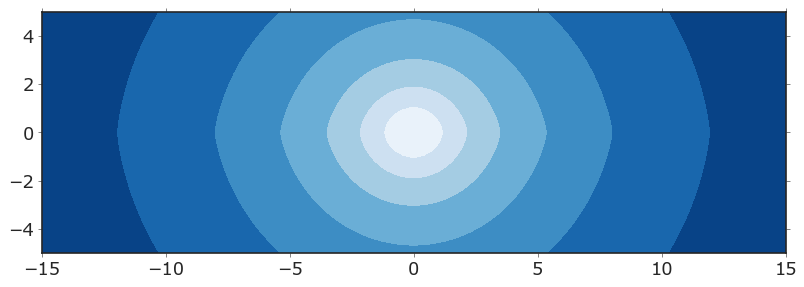

In [3]:
fig,ax = plt.subplots(1, 1, figsize=(12, 4))
x = np.linspace(-15, 15, 100)
z = np.linspace(-5, 5, 100)
_ =pot.plot_contours(grid=(x, 1., z), ax=ax) 

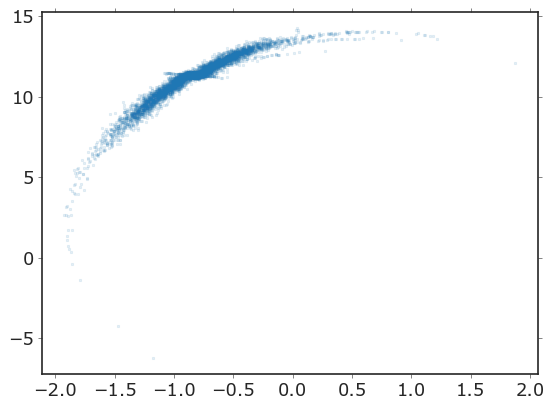

In [8]:
fig, ax=plt.subplots()
ax.scatter(mock_st.x, mock_st.y, s=1, alpha=0.1, marker=',')